# **EJECUTAR**

In [ ]:
# ============================================
# CONFIGURACIÓN Y SEGURIDAD
# ============================================
import os
import requests
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import urllib3
warnings.filterwarnings('ignore')
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Configuración de API Key
# IMPORTANTE: Para usar este código, debes configurar tu API Key como variable de entorno
# Windows: set OPENWEATHER_API_KEY=tu_api_key_aqui
# Linux/Mac: export OPENWEATHER_API_KEY=tu_api_key_aqui
# 
# Obtén tu API key gratuita en: https://openweathermap.org/api
API_KEY = os.getenv('OPENWEATHER_API_KEY')

if not API_KEY:
    raise ValueError(
        "⚠️ ERROR: API Key no configurada.\n"
        "Por favor configura tu API Key de OpenWeatherMap como variable de entorno:\n"
        "  Windows: set OPENWEATHER_API_KEY=tu_api_key_aqui\n"
        "  Linux/Mac: export OPENWEATHER_API_KEY=tu_api_key_aqui\n\n"
        "Obtén tu API key gratuita en: https://openweathermap.org/api"
    )

print("✅ Configuración cargada correctamente")
print(f"🔑 API Key: Configurada desde variable de entorno")


In [ ]:
# ============================================
# CONFIGURACIÓN DE CIUDADES
# ============================================
# Puedes cambiar fácilmente el país o agregar más ciudades
PAISES_CONFIG = {
    'Argentina': [
        "Buenos Aires, AR", "Cordoba, AR", "Rosario, AR", "Mendoza, AR",
        "San Miguel de Tucuman, AR", "La Plata, AR", "Mar del Plata, AR",
        "Salta, AR", "Santa Fe, AR", "San Luis, AR"
    ],
    'Venezuela': [
        "Caracas, VE", "Maracaibo, VE", "Valencia, VE", "Barquisimeto, VE"
    ],
    'Colombia': [
        "Bogota, CO", "Medellin, CO", "Cali, CO", "Barranquilla, CO"
    ],
    'Chile': [
        "Santiago, CL", "Valparaiso, CL", "Concepcion, CL", "La Serena, CL"
    ],
    'Peru': [
        "Lima, PE", "Arequipa, PE", "Trujillo, PE", "Cusco, PE"
    ]
}

# Selecciona el país (puedes cambiarlo fácilmente)
PAIS_SELECCIONADO = 'Argentina'
ciudades = PAISES_CONFIG.get(PAIS_SELECCIONADO, PAISES_CONFIG['Argentina'])

print(f"🌍 País seleccionado: {PAIS_SELECCIONADO}")
print(f"📊 Ciudades a consultar: {len(ciudades)}")

SSLError: HTTPSConnectionPool(host='api.openweathermap.org', port=443): Max retries exceeded with url: /data/2.5/weather?q=Caracas%2C+VE&appid=2f4c488fb0071f271d8970d535d398bc&units=metric&lang=es (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))

In [ ]:
# ============================================
# FUNCIÓN PARA OBTENER DATOS METEOROLÓGICOS
# ============================================
def obtener_clima(ciudad, api_key, max_reintentos=3):
    """
    Obtiene datos meteorológicos de una ciudad con manejo de errores
    """
    url = "https://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": ciudad,
        "appid": api_key,
        "units": "metric",
        "lang": "es"
    }
    
    for intento in range(max_reintentos):
        try:
            # Intentar con verificación SSL primero
            try:
                response = requests.get(url, params=params, timeout=10)
            except requests.exceptions.SSLError:
                # Si falla por SSL (proxy corporativo), intentar sin verificación
                response = requests.get(url, params=params, timeout=10, verify=False)
            
            if response.status_code == 200:
                return response.json(), None
            elif response.status_code == 401:
                return None, "API Key inválida"
            elif response.status_code == 404:
                return None, f"Ciudad '{ciudad}' no encontrada"
            elif response.status_code == 429:
                return None, "Límite de solicitudes excedido"
            else:
                if intento < max_reintentos - 1:
                    continue
                return None, f"Error {response.status_code}"
                
        except requests.exceptions.Timeout:
            if intento < max_reintentos - 1:
                continue
            return None, "Timeout en la solicitud"
        except requests.exceptions.RequestException as e:
            return None, f"Error de conexión: {str(e)}"
    
    return None, "Error después de múltiples intentos"

# ============================================
# OBTENER DATOS DE TODAS LAS CIUDADES
# ============================================
print(f"🌍 Obteniendo datos meteorológicos de {PAIS_SELECCIONADO}...")
print(f"📊 Procesando {len(ciudades)} ciudades...\n")

weather_data = []
errores = []

for ciudad in ciudades:
    data, error = obtener_clima(ciudad, API_KEY)
    if data:
        weather_data.append(data)
        print(f"✅ {data['name']}: {data['weather'][0]['description']} - {data['main']['temp']:.1f}°C")
    else:
        errores.append((ciudad, error))
        print(f"❌ {ciudad}: {error}")

if errores:
    print(f"\n⚠️ {len(errores)} ciudades no pudieron ser procesadas")
else:
    print(f"\n✅ Todas las ciudades procesadas correctamente")


                  Ciudad Descripción del clima  Temperatura (°C)  Humedad (%)  \
0           Buenos Aires         algo de nubes             20.25           53   
1                Córdoba           cielo claro             20.55           48   
2                Rosario           cielo claro             20.33           43   
3                Mendoza           cielo claro             23.35           25   
4  San Miguel de Tucumán            muy nuboso             22.25           52   
5               La Plata           cielo claro             21.01           53   
6          Mar del Plata           cielo claro             19.93           45   
7                  Salta                 nubes             18.62           85   
8               Santa Fe           cielo claro             21.71           54   
9               San Luis           cielo claro             24.41           27   

   Viento (km/h)  
0           6.26  
1           6.17  
2           6.17  
3           3.50  
4           1

In [ ]:

# ============================================
# CREAR DATAFRAME CON DATOS COMPLETOS
# ============================================
columnas = [
    'Ciudad', 'Latitud', 'Longitud', 'Descripción del clima',
    'Temperatura (°C)', 'Sensación térmica (°C)', 'Temperatura mínima (°C)',
    'Temperatura máxima (°C)', 'Humedad (%)', 'Presión (hPa)',
    'Viento (km/h)', 'Dirección del viento (°)', 'Visibilidad (km)',
    'Ícono del clima', 'País'
]

datos = []

for data in weather_data:
    # Obtener dirección del viento si está disponible
    direccion_viento = data.get('wind', {}).get('deg', 'N/A')
    
    # Convertir visibilidad de metros a km
    visibilidad = data.get('visibility', 0) / 1000 if data.get('visibility') else 'N/A'
    
    datos.append([
        data['name'],
        data['coord']['lat'],
        data['coord']['lon'],
        data['weather'][0]['description'],
        data['main']['temp'],
        data['main'].get('feels_like', 'N/A'),
        data['main']['temp_min'],
        data['main']['temp_max'],
        data['main']['humidity'],
        data['main']['pressure'],
        data['wind']['speed'] * 3.6,  # Convertir m/s a km/h
        direccion_viento,
        visibilidad,
        data['weather'][0]['icon'],
        data['sys']['country']
    ])

df = pd.DataFrame(datos, columns=columnas)

# Mostrar resumen estadístico
print("\n" + "="*60)
print("📊 RESUMEN ESTADÍSTICO")
print("="*60)
print(f"Temperatura promedio: {df['Temperatura (°C)'].mean():.1f}°C")
print(f"Temperatura mínima: {df['Temperatura (°C)'].min():.1f}°C")
print(f"Temperatura máxima: {df['Temperatura (°C)'].max():.1f}°C")
print(f"Humedad promedio: {df['Humedad (%)'].mean():.1f}%")
print(f"Viento promedio: {df['Viento (km/h)'].mean():.1f} km/h")
print("="*60 + "\n")

# Mostrar tabla completa
print("📋 DATOS COMPLETOS:")
print(df.to_string(index=False))

In [ ]:
# ============================================
# INSTALAR DEPENDENCIAS (si es necesario)
# ============================================
# Descomenta la siguiente línea si necesitas instalar las dependencias
# !pip install folium pandas numpy scipy matplotlib requests

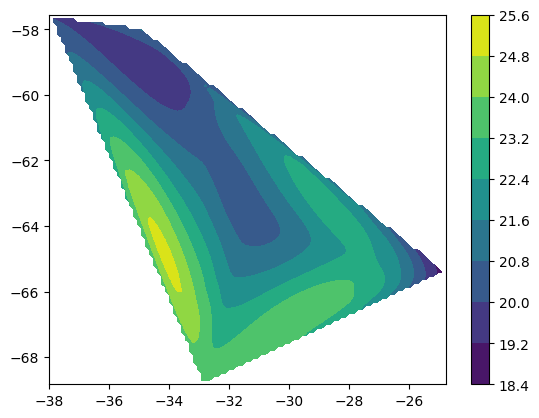

In [ ]:
# ============================================
# CREAR MAPA INTERACTIVO MEJORADO
# ============================================
# Calcular centro del mapa basado en las ciudades
lat_centro = df['Latitud'].mean()
lon_centro = df['Longitud'].mean()

# Crear mapa base
m = folium.Map(
    location=[lat_centro, lon_centro],
    zoom_start=6,
    tiles='OpenStreetMap'
)

# Agregar capa de calor de temperatura
heat_data = [[row['Latitud'], row['Longitud'], row['Temperatura (°C)']] 
             for idx, row in df.iterrows()]
HeatMap(heat_data, radius=25, blur=15, max_zoom=1).add_to(m)

# Agregar marcadores con información detallada
marker_cluster = MarkerCluster().add_to(m)

for idx, row in df.iterrows():
    # Determinar color del marcador según temperatura
    temp = row['Temperatura (°C)']
    if temp < 10:
        color = 'blue'
    elif temp < 20:
        color = 'green'
    elif temp < 30:
        color = 'orange'
    else:
        color = 'red'
    
    # Crear popup con información detallada
    popup_html = f"""
    <div style="font-family: Arial; width: 250px;">
        <h3 style="margin: 5px 0; color: #2c3e50;">{row['Ciudad']}</h3>
        <hr style="margin: 5px 0;">
        <p style="margin: 3px 0;"><b>🌡️ Temperatura:</b> {row['Temperatura (°C)']:.1f}°C</p>
        <p style="margin: 3px 0;"><b>🌤️ Estado:</b> {row['Descripción del clima']}</p>
        <p style="margin: 3px 0;"><b>💧 Humedad:</b> {row['Humedad (%)']}%</p>
        <p style="margin: 3px 0;"><b>💨 Viento:</b> {row['Viento (km/h)']:.1f} km/h</p>
        <p style="margin: 3px 0;"><b>📊 Presión:</b> {row['Presión (hPa)']} hPa</p>
        <p style="margin: 3px 0;"><b>👁️ Visibilidad:</b> {row['Visibilidad (km)']} km</p>
        <p style="margin: 3px 0;"><b>📅 Actualizado:</b> {datetime.now().strftime('%H:%M:%S')}</p>
    </div>
    """
    
    folium.Marker(
        location=[row['Latitud'], row['Longitud']],
        popup=folium.Popup(popup_html, max_width=300),
        icon=folium.Icon(color=color, icon='cloud', prefix='fa'),
        tooltip=f"{row['Ciudad']}: {row['Temperatura (°C)']:.1f}°C"
    ).add_to(marker_cluster)

# Guardar mapa
nombre_archivo = f'mapa_clima_{PAIS_SELECCIONADO.lower()}_{datetime.now().strftime("%Y%m%d")}.html'
m.save(nombre_archivo)
print(f"🗺️ Mapa guardado como: {nombre_archivo}")

# Mostrar mapa
m

In [ ]:
# ============================================
# VISUALIZACIÓN DE ISOTERMAS MEJORADA
# ============================================
if len(df) >= 3:  # Necesitamos al menos 3 puntos para interpolación
    posiciones = np.array([(lat, lon) for lat, lon in zip(df['Latitud'], df['Longitud'])])
    temperaturas = df['Temperatura (°C)'].values
    
    # Crear cuadrícula para interpolación
    lat_min, lat_max = df['Latitud'].min(), df['Latitud'].max()
    lon_min, lon_max = df['Longitud'].min(), df['Longitud'].max()
    
    # Expandir un poco el área para mejor visualización
    lat_range = lat_max - lat_min
    lon_range = lon_max - lon_min
    lat_min -= lat_range * 0.1
    lat_max += lat_range * 0.1
    lon_min -= lon_range * 0.1
    lon_max += lon_range * 0.1
    
    grid_x, grid_y = np.mgrid[lat_min:lat_max:100j, lon_min:lon_max:100j]
    grid_z = griddata(posiciones, temperaturas, (grid_x, grid_y), method='cubic')
    
    # Crear figura mejorada
    plt.figure(figsize=(12, 8))
    contour = plt.contourf(grid_x, grid_y, grid_z, levels=20, cmap='RdYlBu_r')
    plt.colorbar(contour, label='Temperatura (°C)')
    
    # Agregar puntos de las ciudades
    scatter = plt.scatter(df['Longitud'], df['Latitud'], 
                         c=df['Temperatura (°C)'], 
                         s=100, edgecolors='black', 
                         linewidth=2, cmap='RdYlBu_r', zorder=5)
    
    # Agregar etiquetas de ciudades
    for idx, row in df.iterrows():
        plt.annotate(row['Ciudad'], 
                    (row['Longitud'], row['Latitud']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold')
    
    plt.xlabel('Longitud', fontsize=12)
    plt.ylabel('Latitud', fontsize=12)
    plt.title(f'Mapa de Isotermas - {PAIS_SELECCIONADO}\n{datetime.now().strftime("%Y-%m-%d %H:%M")}', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Guardar imagen
    nombre_imagen = f'isotermas_{PAIS_SELECCIONADO.lower()}_{datetime.now().strftime("%Y%m%d")}.png'
    plt.savefig(nombre_imagen, dpi=300, bbox_inches='tight')
    print(f"📈 Gráfico de isotermas guardado como: {nombre_imagen}")
    
    plt.show()
else:
    print("⚠️ Se necesitan al menos 3 ciudades para crear el mapa de isotermas")
